# Class Label 

In this notebook, we're curious what happened if we delete a class label.

In [53]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False)

## Delete Cat and Remote

In [54]:
# The model we are running below are specifically trained for the COCO dataset

# To do that, we have to first load the class categories that the COCO-trained models can detect
# "N/A" refers to the empty set / unsured output
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization: the color will be applied to the bounding boxes for displaying the object detection results 
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [55]:
# standard PyTorch mean-std input image normalization
# This helps to ensure the input images are in the same scale that the model is trained on 
transform = T.Compose([
    T.Resize(800), # resize img to 800 pixels 
    T.ToTensor(), # this step is necessary as it convert the image object to tensor
    T.Normalize([0.485, 0.456, 0.406], # Normalize using ImageNet 
                [0.229, 0.224, 0.225]) # Normalize using ImageNet std 
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [56]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

### Load the TEDR model and run predictions. 

In [57]:
from transformers import DetrConfig, DetrForObjectDetection
# Load the pre-trained model with the configuration
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval()  # Set the model to evaluation mode


Using cache found in /home/smooi/.cache/torch/hub/facebookresearch_detr_main
/files/smooi/pytorch_env/pytorch_env/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/files/smooi/pytorch_env/pytorch_env/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [58]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw).convert("RGB")


In [59]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img) # predict the image 

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

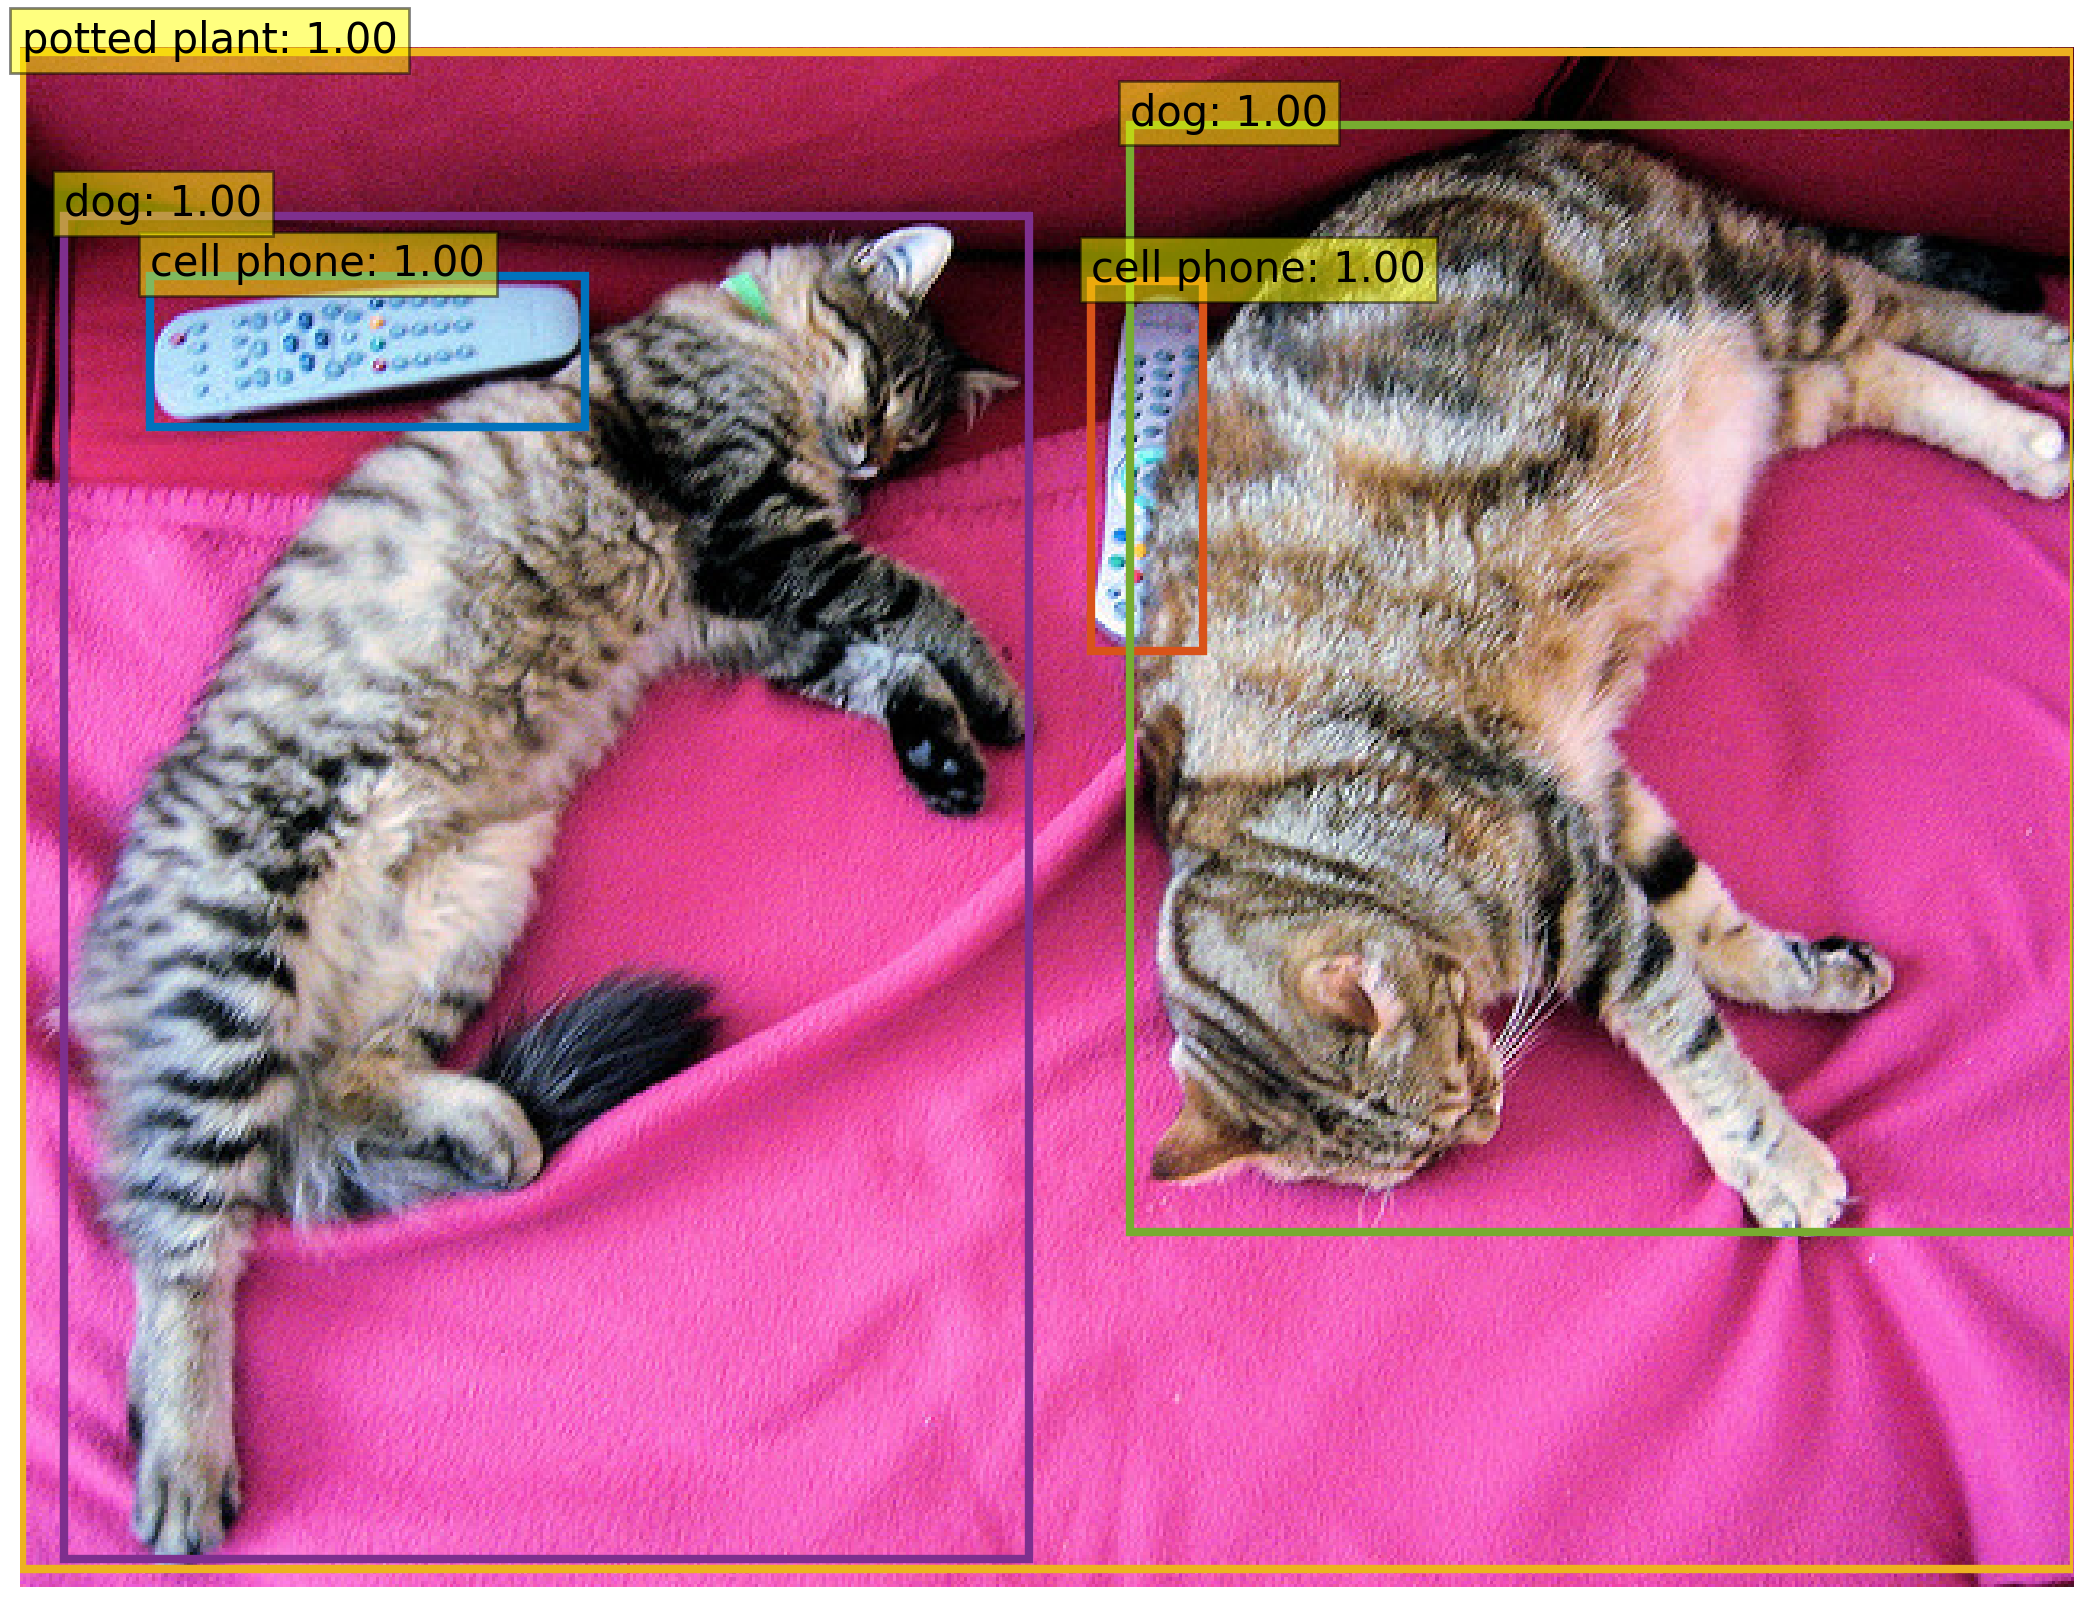

In [60]:
plot_results(im, probas[keep], bboxes_scaled)

### Observation:

It is now observed that after we delete the 'cat' and 'remote' label, now the real cats are classified as 'dog', and the real remote control became 'cell phone', even the couch become something else (potted plant).

In [61]:
# Let's try to add the two labels back and see if it can go back to the prediction as shown in main.ipynb.

# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'remote',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [62]:
# standard PyTorch mean-std input image normalization
# This helps to ensure the input images are in the same scale that the model is trained on 
transform = T.Compose([
    T.Resize(800), # resize img to 800 pixels 
    T.ToTensor(), # this step is necessary as it convert the image object to tensor
    T.Normalize([0.485, 0.456, 0.406], # Normalize using ImageNet 
                [0.229, 0.224, 0.225]) # Normalize using ImageNet std 
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [63]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [64]:
from transformers import DetrConfig, DetrForObjectDetection
# Load the pre-trained model with the configuration
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval()  # Set the model to evaluation mode


Using cache found in /home/smooi/.cache/torch/hub/facebookresearch_detr_main
/files/smooi/pytorch_env/pytorch_env/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/files/smooi/pytorch_env/pytorch_env/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [65]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw).convert("RGB")


In [66]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img) # predict the image 

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

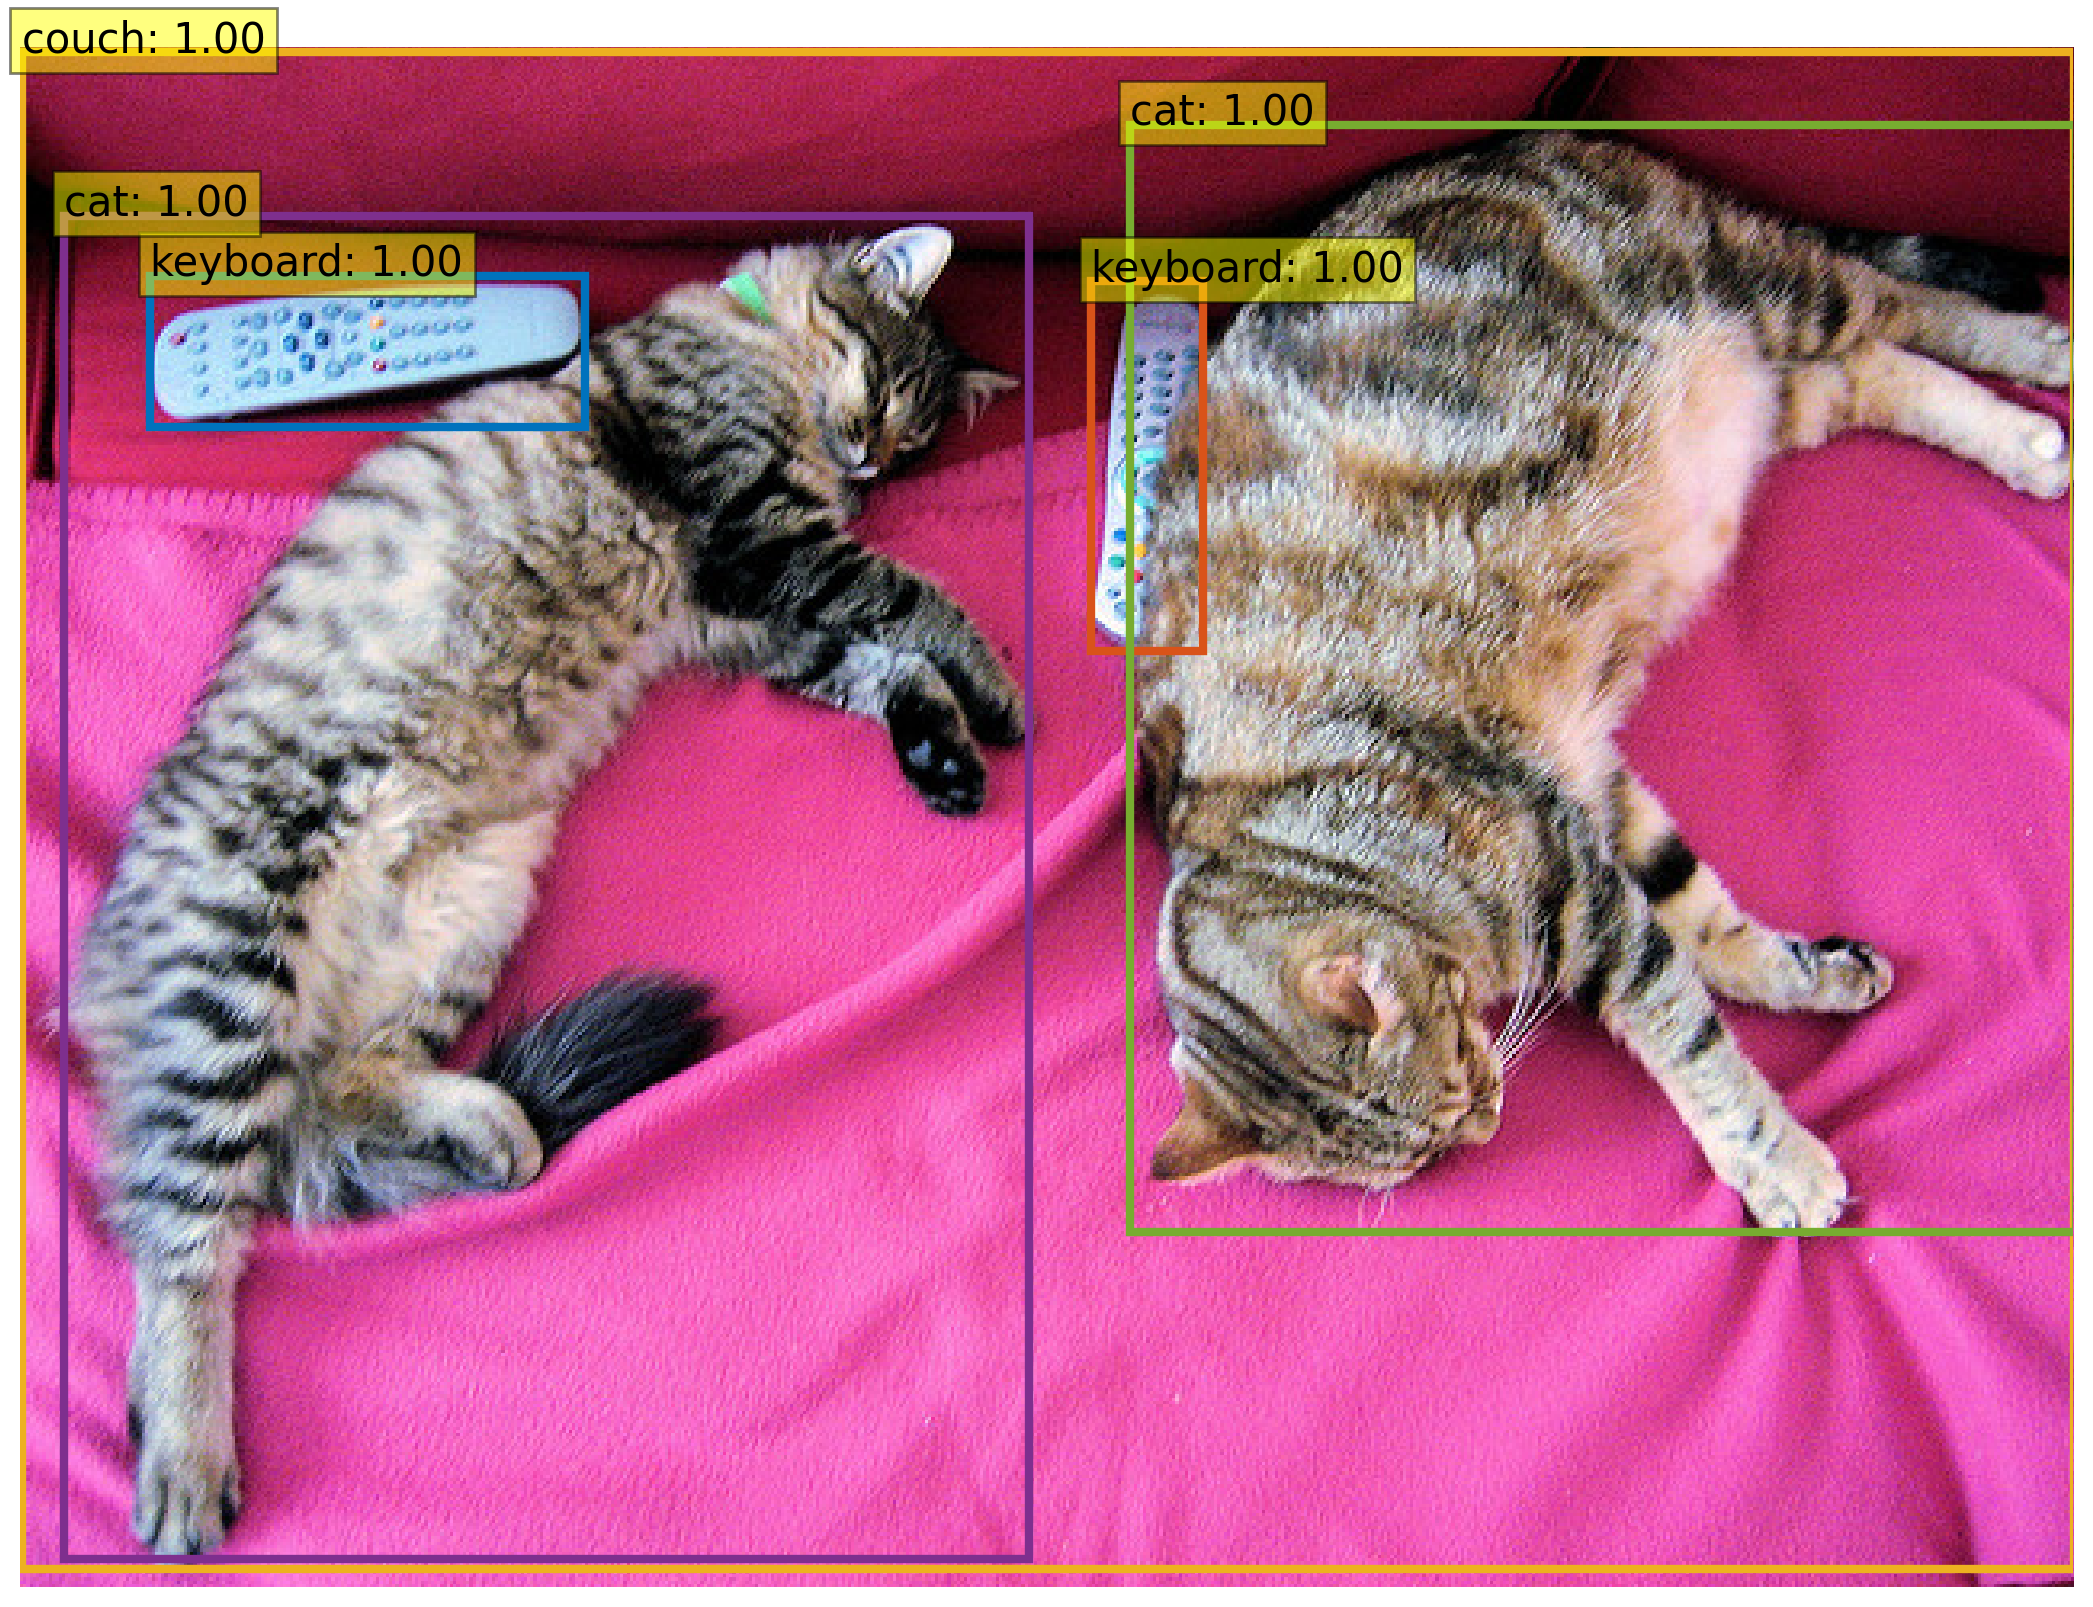

In [67]:
plot_results(im, probas[keep], bboxes_scaled)